# Exprimenting and Modeling

In [3]:
import mlflow
# Data Manipulation and Analysis
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
import xgboost as xgb

## Loading data and splitting it 

In [4]:
norm_data = pd.read_csv('../data/processed/expriment_df.csv',delimiter=',')
norm_data.set_index('CUSTOMER_ID', inplace=True)
norm_data.head()

,COLLEGE,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,LESSTHAN600k,CHILD,JOB_CLASS,REVENUE,...,REPORTED_SATISFACTION_unsat,REPORTED_SATISFACTION_very_sat,REPORTED_SATISFACTION_very_unsat,REPORTED_USAGE_LEVEL_avg,REPORTED_USAGE_LEVEL_high,REPORTED_USAGE_LEVEL_little,REPORTED_USAGE_LEVEL_very_high,REPORTED_USAGE_LEVEL_very_little,CHURNED_LEAVE,CHURNED_STAY
CUSTOMER_ID,,,,,,,,,,,,,,,,,,,,,
C100000,0,0.342068,-1.235851,-0.947823,-0.892885,1.521888,0,4,3,0.094061,...,0,0,1,0,0,1,0,0,0,1
C100001,1,-0.405661,-0.720966,0.883351,-0.331492,-0.440526,1,0,1,-1.159304,...,1,0,0,0,0,1,0,0,1,0
C100006,0,-0.643620,0.860414,-0.947823,-0.406344,1.677104,0,4,2,-0.595290,...,0,0,0,0,0,0,0,1,0,1
C100008,0,-0.520608,-0.300027,1.214144,-0.892885,1.868824,0,3,3,-1.451756,...,1,0,0,0,0,0,1,0,1,0
C100010,1,-0.138431,-0.189826,1.414983,-0.892885,-0.435752,1,2,3,-1.639761,...,0,0,1,0,0,1,0,0,1,0


For split we picking only the relevent columns 

In [5]:
relevant_columns = [
    'HOUSE',
    'OVERCHARGE',
    'DATA',
    'INCOME',
    'OVER_15MINS_CALLS_PER_MONTH',
    'REPORTED_SATISFACTION_very_sat',
    'LEFTOVER',
    'HANDSET_PRICE',
    'AVERAGE_CALL_DURATION',
    'TIME_CLIENT',
    'REPORTED_SATISFACTION_very_unsat'
]

X = norm_data[relevant_columns]
y = norm_data['CHURNED_STAY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train XGboost model as our baseline and first exprimentation

In [6]:
xgb_clf = xgb.XGBClassifier()
xgb_clf = xgb_clf.fit(X_train, y_train)

## Eval Trained model 

## Output pd Result
* in this step we :
    - we predict on the test set 
    - for we encoding the ground truth and the prediction
    - we setting reuls for discount proposition based on the proba of the model
    - results_df hold the final result requested by the client  

ROC AUC: 0.8400982963304038


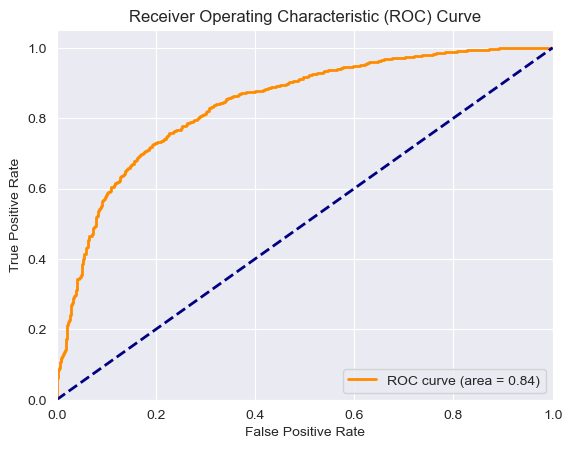

In [71]:
def get_auc(xgb_clf, X_test, y_test):
    # Predict probabilities
    y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]
    # Compute ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC: {roc_auc}")
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc_value = auc(fpr, tpr)
    return roc_auc_value, roc_auc, fpr, tpr

roc_auc_value, roc_auc, fpr, tpr = get_auc(xgb_clf, X_test,y_test)

def plot_auc(fpr, tpr,roc_auc_value):
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
plot_auc(fpr, tpr,roc_auc_value)

In [55]:
def get_results(xgb_clf, X_test):
    customer_ids = X_test.index
    # Predict probabilities and labels
    churn_probabilities = xgb_clf.predict_proba(X_test)[:, 1]
    churn_predictions = xgb_clf.predict(X_test)
    churn_predictions = ['LEAVE' if label == 0 else 'STAY' for label in churn_predictions]
    real_churn_labels = ['LEAVE' if label == 0 else 'STAY' for label in y_test]
    return customer_ids, churn_probabilities,churn_predictions,real_churn_labels
    
customer_ids, churn_probabilities,churn_predictions,real_churn_labels = get_results(xgb_clf, X_test)

In [18]:
# Determine CLIENT_TO_CONTACT based on churn label
client_to_contact = ['YES' if label == 'LEAVE' else 'NO' for label in churn_predictions]

def propose_discount(churn_label, probability):
    # Apply discounts only to those predicted to leave
    if churn_label == 'LEAVE':
        if probability > 0.75:
            return '20%'
        elif probability > 0.5:
            return '15%'
        elif probability > 0.25:
            return '10%'
        else:
            return '5%'
    else:
        return '0%'  # No discount for those predicted to stay


# Calculate discounts for each customer
discounts = [propose_discount(label, prob) for label, prob in zip(churn_predictions, churn_probabilities)]

# Create the DataFrame
results_df = pd.DataFrame({
    'CUSTOMER_ID': customer_ids,
    'CHURN_Ground_truth_Label' : real_churn_labels,
    'CHURN_PREDS': churn_predictions,
    'CHURN_PROBABILITY': churn_probabilities,
    'CLIENT_TO_CONTACT': client_to_contact,
    'DISCOUNT': discounts
})

In [19]:
# Determine CLIENT_TO_CONTACT based on churn label
client_to_contact = ['YES' if label == 'LEAVE' else 'NO' for label in churn_predictions]

def propose_discount(churn_label, probability):
    # Apply discounts only to those predicted to leave
    if churn_label == 'LEAVE':
        if probability > 0.75:
            return '20%'
        elif probability > 0.5:
            return '15%'
        elif probability > 0.25:
            return '10%'
        else:
            return '5%'
    else:
        return '0%'  # No discount for those predicted to stay


# Calculate discounts for each customer
discounts = [propose_discount(label, prob) for label, prob in zip(churn_predictions, churn_probabilities)]

# Create the DataFrame
results_df = pd.DataFrame({
    'CUSTOMER_ID': customer_ids,
    'CHURN_Ground_truth_Label' : real_churn_labels,
    'CHURN_PREDS': churn_predictions,
    'CHURN_PROBABILITY': churn_probabilities,
    'CLIENT_TO_CONTACT': client_to_contact,
    'DISCOUNT': discounts
})
# Display the DataFrame
# Save to CSV
results_df.to_csv('customer_discounts.csv', index=False)

# Display the DataFrame
results_df

,CUSTOMER_ID,CHURN_Ground_truth_Label,CHURN_PREDS,CHURN_PROBABILITY,CLIENT_TO_CONTACT,DISCOUNT
0,C106601,STAY,STAY,0.974436,NO,0%
1,C100760,STAY,STAY,0.799224,NO,0%
2,C109872,STAY,STAY,0.918493,NO,0%
3,C110408,STAY,STAY,0.970744,NO,0%
4,C113945,LEAVE,STAY,0.807691,NO,0%
...,...,...,...,...,...,...
2265,C108915,STAY,STAY,0.951487,NO,0%
2266,C103480,LEAVE,LEAVE,0.060307,YES,5%
2267,C101038,STAY,STAY,0.736183,NO,0%
2268,C112906,STAY,STAY,0.560056,NO,0%


## No Labled data testing 
    - this section is testing the model on the validation csv that doesnt have labels 

In [20]:
val_data = pd.read_csv('../data/raw/validation.csv',delimiter=',')
val_data.set_index('CUSTOMER_ID', inplace=True)
val_data.head()

,COLLEGE,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,LESSTHAN600k,CHILD,JOB_CLASS,REVENUE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN
CUSTOMER_ID,,,,,,,,,,,,,,,,,
C100002,one,80.000000,45452.5,75,65,342741.0,True,3,1,149.0,300,3,2.2,2,unsat,little,considering
C100003,zero,536.842105,40703.5,90,0,215904.0,True,1,1,176.0,384,4,2.4,13,unsat,very_high,actively_looking_into_it
C100004,zero,256.578947,35563.0,52,0,341828.0,True,2,3,124.0,371,5,2.3,12,very_sat,avg,considering
C100005,zero,466.666667,66072.5,0,8,257222.0,True,3,1,279.0,324,1,2.8,5,very_sat,very_little,actively_looking_into_it
C100007,zero,150.000000,21901.5,0,0,800811.0,False,1,3,128.0,164,1,1.5,12,avg,very_high,perhaps


## Cross validation training

In [47]:
from sklearn.metrics import make_scorer, log_loss, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Define scorers for log loss and AUC
scorer = {
    'log_loss': make_scorer(log_loss, greater_is_better=False),
    'roc_auc': 'roc_auc'
}

In [48]:
# Initialize XGBoost model
xgb1 = xgb.XGBClassifier(objective='binary:logistic')

# Define hyperparameters to search
param_grid = {
    'max_depth': [3, 4, 5],
    'eta': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'n_estimators': [100, 200]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb1,
    param_grid=param_grid,
    scoring=scorer,
    cv=KFold(n_splits=5, random_state=42, shuffle=True),
    refit='roc_auc',  
    verbose=1
)

# Fit GridSearchCV
grid_search.fit(X, y)

# Get the best model from grid search
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [51]:
type(best_model)

xgboost.sklearn.XGBClassifier

ROC AUC: 0.9433308793170551


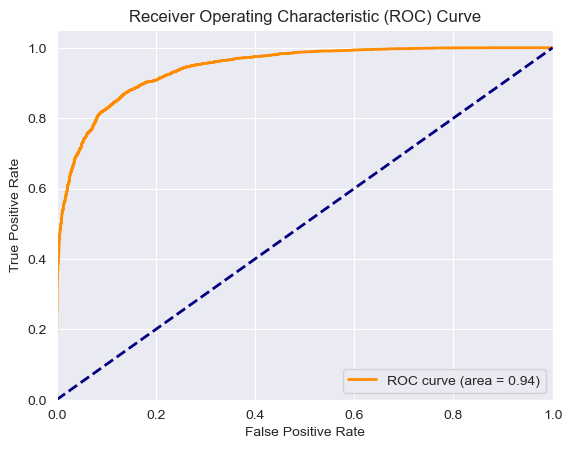

In [72]:
train_roc_auc_value, train_roc_auc, train_fpr, train_tpr = get_auc(best_model, X_train,y_train)

plot_auc(train_fpr, train_tpr,train_roc_auc_value) 

ROC AUC: 0.942244232681361


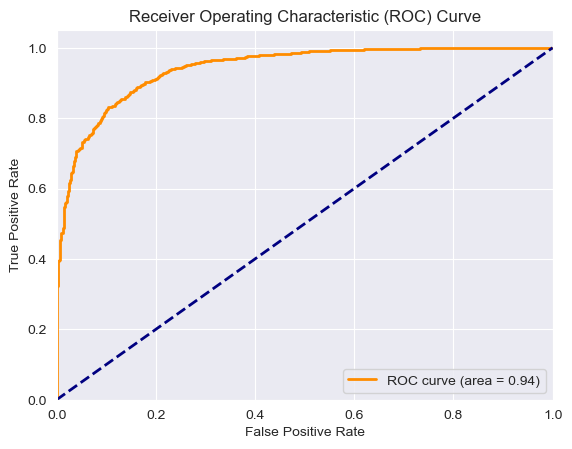

In [76]:
test_roc_auc_value, test_roc_auc, test_fpr, test_tpr = get_auc(best_model, X_test,y_test)

plot_auc(test_fpr, test_tpr,test_roc_auc_value)

In [56]:
customer_ids, churn_probabilities,churn_predictions,real_churn_labels = get_results(best_model, X_test)

## Retrieve Feature Importance
Gain: Average gain of splits which use the feature.
Cover: Average coverage of splits which use the feature.
Frequency: Number of times a feature is used in all trees. (we will use this one)

In [77]:
importance = best_model.get_booster().get_score(importance_type='weight')
# convert into a df for viz
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
2,DATA,923.0
0,HOUSE,656.0
9,TIME_CLIENT,639.0
3,INCOME,572.0
7,HANDSET_PRICE,534.0
1,OVERCHARGE,513.0
6,LEFTOVER,510.0
4,OVER_15MINS_CALLS_PER_MONTH,286.0
8,AVERAGE_CALL_DURATION,215.0
10,REPORTED_SATISFACTION_very_unsat,79.0


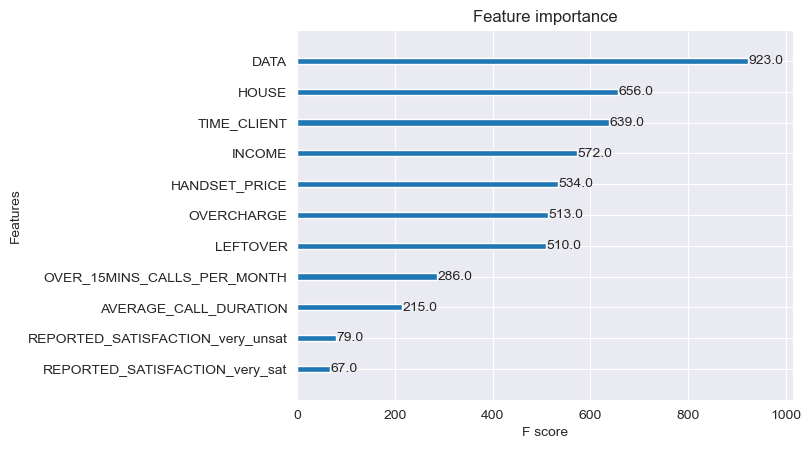

In [81]:
from xgboost import plot_importance

# Plot feature importance
plot_importance(best_model, importance_type='weight')
plt.show()

In [57]:
# Determine CLIENT_TO_CONTACT based on churn label
client_to_contact = ['YES' if label == 'LEAVE' else 'NO' for label in churn_predictions]

# Calculate discounts for each customer
discounts = [propose_discount(label, prob) for label, prob in zip(churn_predictions, churn_probabilities)]

# Create the DataFrame
grid_cv_results_df = pd.DataFrame({
    'CUSTOMER_ID': customer_ids,
    'CHURN_Ground_truth_Label': real_churn_labels,
    'CHURN_PREDS': churn_predictions,
    'CHURN_PROBABILITY': churn_probabilities,
    'CLIENT_TO_CONTACT': client_to_contact,
    'DISCOUNT': discounts
})
# Display the DataFrame
# Save to CSV
grid_cv_results_df.to_csv('grid_cv_customer_discounts.csv', index=False)

# Display the DataFrame
grid_cv_results_df

,CUSTOMER_ID,CHURN_Ground_truth_Label,CHURN_PREDS,CHURN_PROBABILITY,CLIENT_TO_CONTACT,DISCOUNT
0,C106601,STAY,STAY,0.930200,NO,0%
1,C100760,STAY,STAY,0.916104,NO,0%
2,C109872,STAY,STAY,0.977066,NO,0%
3,C110408,STAY,STAY,0.968012,NO,0%
4,C113945,LEAVE,STAY,0.515412,NO,0%
...,...,...,...,...,...,...
2265,C108915,STAY,STAY,0.941718,NO,0%
2266,C103480,LEAVE,LEAVE,0.096899,YES,5%
2267,C101038,STAY,STAY,0.722598,NO,0%
2268,C112906,STAY,STAY,0.631151,NO,0%


## MLflow